# TensorFlow 2.0 alpha - Neural Style Transfer
### Compose One Image in the Style of Another Image

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Download 2 Images

In [2]:
turtle_path = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
kadinsky_path = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the Input
#### Select the Style Image and the Content Image

In [3]:
content_path = turtle_path
style_path = kadinsky_path

#### Define a Function to Load an Image - Limit the Max Dimension to 512 pixels

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_jpeg(img)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long = max(shape)
  scale = max_dim/long

  new_shape = tf.cast(shape*scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

#### Define a Function to Display an Image

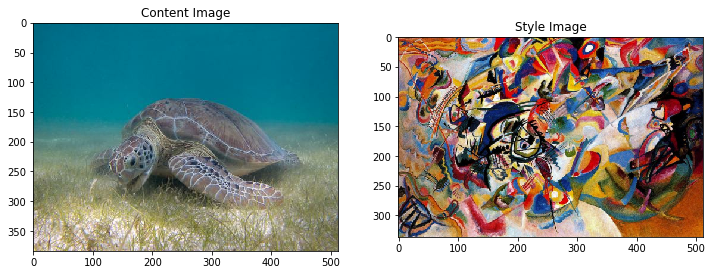

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.figure(figsize=(12, 12))

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define Content and Style Representations
#### Intermediate Layers contribute to these Representations - the 1st few layer activations represent low-level features (edges, texture) - Later layers represent high-level features (eyes, wheels)
#### Use the VGG19 Network Architecture

In [6]:
# Load VGG19 - test it on the image

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
r = vgg(x)

In [7]:
#tf.keras.applications.vgg19.decode_predictions(r.numpy())

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[np.argsort(r)[0,::-1][:5]+1])

['loggerhead' 'leatherback turtle' 'hermit crab' 'terrapin' 'mud turtle']


#### Load a VGG19 without the Classification Head - List Layer names

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


#### Decide Intermediate Layers from the network to represent Style and Content of the Image

In [9]:
# Content layers to pull out Feature Maps

content_layers = ['block5_conv2'] 

# Style layers of interest

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Important to access the intermediate layers, to infuence the raw features of the image
## Build Model
#### Define Function that builds a VGG19 model - Return a list of Intermediate Layer Outputs

In [10]:
# Load pretrained vgg19, trained on imagenet data

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
    
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [11]:
# Create model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at statistics of output of each layer

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8867
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.24
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179478



## Calculate Style
#### The Content of an image is represented by values of the Intermediate Feature Maps
#### The Style of an image is described by the Means and Correlations across different Feature Maps
### a Gram Matrix contains this info - create using tf.linalg.einsum

In [12]:
# Gram Matrix

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract Style and Content

In [13]:
# Build model that returns the Style/Content Tensors

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, input):
    "Expects float input in [0,1]"
    
    input = input*255.0
    
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(input)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

#### When called on an image, model returns Gram Matrix (style) of the style_layers, and the Content of the content_layers

In [14]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.03488168
    max:  26723.258
    mean:  780.96204

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  95840.18
    mean:  11674.933

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  296185.9
    mean:  7241.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3164085.2
    mean:  104884.49

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  66307.836
    mean:  650.05994

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  939.0782
    mean:  8.983593


## Run Gradient Descent
#### With this Style and Content Extractor - implement the Style Transfer Algorithm
#### Done by calculating MSE for image's output relative to each target, and taking the weighted sums of the losses

In [15]:
# Set Style and Content Target Values

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#### Define a tf.Variable - to contain the Image to be optimized

In [16]:
image = tf.Variable(content_image)

#### This is a Float Image - define Function to keep pixel values between 0 - 1

In [17]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### Create an Optimizer - LBFGS recommended, however Adam works as well

In [18]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#### To optimize, use a Weighted Combination of the Two Losses - to get Total Loss

In [19]:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight/num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight/num_content_layers
    loss = style_loss+content_loss
    return loss

#### Update image using tf.GradientTape

In [20]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#### Run a few Steps to Test

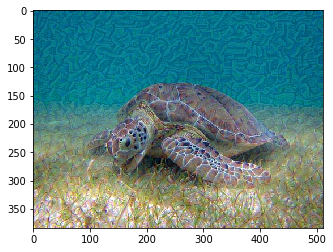

In [21]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

### The model appears to be working - Perform longer Optimization

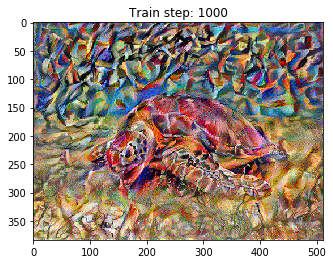

Total time: 4686.0


In [22]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Total Variation Loss
#### This approach produces many high frequency artifacts - Address this using a Regularization Term on the high frequency elements of the image
#### This is called Total Variation Loss, when done in Style Transfer

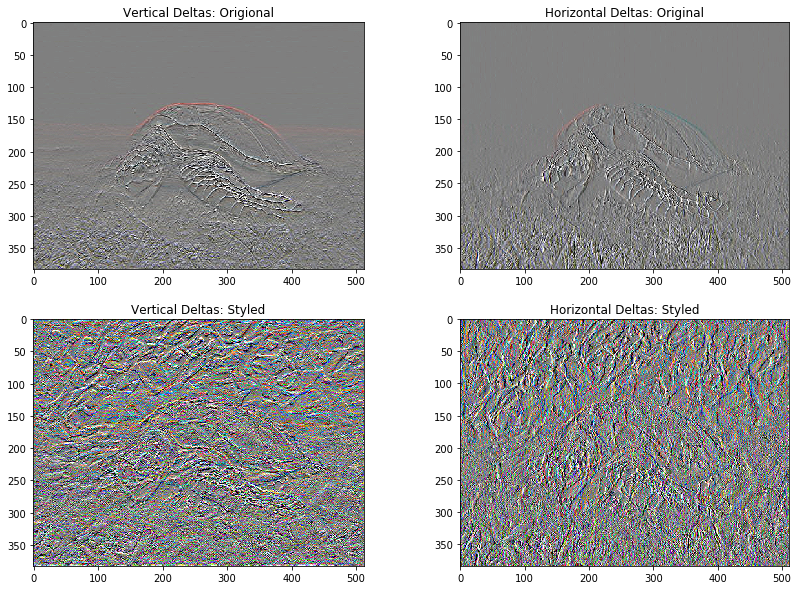

In [23]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Vertical Deltas: Origional")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Horizontal Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Vertical Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Horizontal Deltas: Styled")

#### The high frequency elements have Increased - from Original to Styled
#### This high frequency component acts as an Edge-detector - similar results can be obtained with the *Sobel Edge Detector*

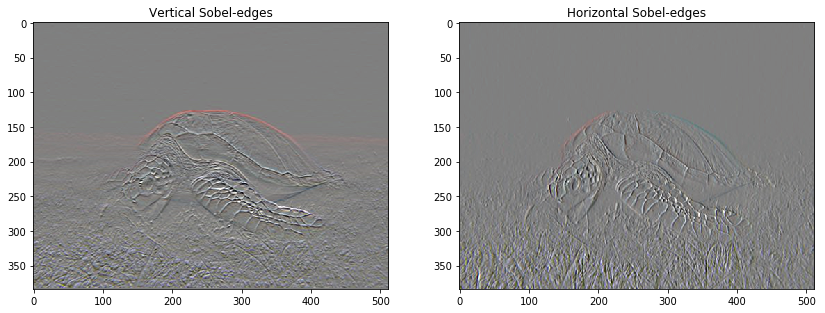

In [24]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Vertical Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Horizontal Sobel-edges")

#### The Regularization Loss associated with this - Sum of the Squares of the values

In [25]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2)+tf.reduce_mean(y_deltas**2)

## Re-run the Optimization
#### Choose a Weight for the total_variation_loss

In [26]:
total_variation_weight=1e8

#### Include this in the train_step function

In [27]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#### Re-initialize with the Optimization Variable

In [28]:
image = tf.Variable(content_image)

#### Run the Optimization

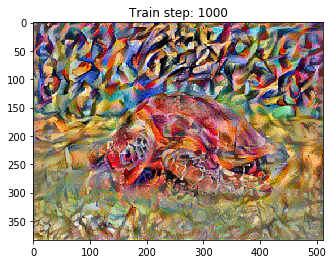

Total time: 5415.4


In [29]:
import time
start = time.time()

epochs = 10
steps = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Save the Resulting Image

In [30]:
!pip install Pillow

import PIL
from PIL import Image 

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
file_name = 'kandinsky-turtle.png'
mpl.image.imsave(file_name, image[0])

try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)